# Combining heat and power
The CHPAsset class represents an asset that can generate both heat and power at the same time and models starting procedures, minimum loads, ramping and a minimum runtime.

## Technical Details
### Input Parameters
Possible input parameters of the CHPAsset are
- Ramp $r$
- Conversion efficiency $\alpha$ from heat to power.
- Maximum share heat $\beta$
- Minimum capacity $l_t$ for every timestep $t \in \left\{0,\dots, T-1\right\}$
- Maximum capacity $u_t$ for every timestep $t \in \left\{0,\dots, T-1\right\}$
- Dispatch power $x_{-1}$ from the previous timestep
- Dispatch heat $w_{-1}$ from the previous timestep
- Number $k_{on}$ of timesteps the asset has already been running
- Number $k_{off}$ of timesteps the asset has already been of
- Minimum runtime $m_{run}$
- Minimum downtime $m_{down}$

### Output variables
The following variables are computed for a CHPAsset that runs for $T$ timesteps:
- Dispatch power $x_t \in \mathbb{R}$, for every timestep $t \in \left\{0,\dots, T-1\right\}$
- Dispatch heat $w_t \in \mathbb{R}$, for every timestep $t \in \left\{0,\dots, T-1\right\}$
- "On"-variable $a_t \in \left\{0,1\right\}$, for every timestep $t \in \left\{0,\dots, T-1\right\}$
- "Start"-variable $s_t \in \left\{0,1\right\}$, for every timestep $t \in \left\{0,\dots, T-1\right\}$

When they are not needed to enforce a minimum runtime, start costs or similar, the "on" and "start" variables are removed.

### Variable bounds
The output variables are within the following bounds in every timestep $t \in \left\{0,\dots, T-1\right\}$:
- $0 \leq x_t \leq u_t$
- $0 \leq w_t \leq \beta u_t$
- $0 \leq a_t \leq 1$
- $0 \leq s_t \leq 1$

### Constraints
The following constraints are used in the asset

- **Ramp**: Ensure that the increase/decrease of the virtual dispatch $\tilde{x}_t = x_t + \alpha w_t$ is bounded by $r$, i.e.   
	\begin{align*}
					-r \leq \tilde{x}_t-\tilde{x}_{t-1} \leq r,
	\end{align*} 
&emsp;&nbsp;&nbsp;&nbsp; for $t \in \left\{0,\dots, T-1\right\}$.

-  **Minimum and maximum capacity**: The virtual dispatch $\tilde{x}_t = x_t + \alpha w_t$ is 0 when $a_t = 0$, i.e. the asset is "off", or between minimum and maximum capacity, i.e.
\begin{align*} a_t l_t \leq \tilde{x}_t \leq a_t u_t, \end{align*} 
&emsp;&nbsp;&nbsp;&nbsp; for $t \in \left\{0,\dots, T-1\right\}$.

- **Start constraints**: When the "on" variable changes from "off" to "on", the start variable has to be 1, i.e.
\begin{align*}s_t \geq a_t - a_{t-1},\end{align*} 
&emsp;&nbsp;&nbsp;&nbsp; for $t \in \left\{1,\dots, T-1\right\}$. <br>
&emsp;&nbsp;&nbsp;&nbsp; If $k_{on} = 0$, i.e. previous state $a_{-1}$ is "off", we need the additional condition 
\begin{align*}s_0 \geq a_0.\end{align*}

- **Minimum runtime**: Ensure that the asset follows the minimum runtime $m_{run}$, i.e.
\begin{align*}a_t \geq s_{t-i}\end{align*} 
&emsp;&nbsp;&nbsp;&nbsp; for $t \in \left\{1,\dots, T-1\right\}$ and $i \in \left\{1, \dots, m_{run}-1\right\}$. <br>
&emsp;&nbsp;&nbsp;&nbsp; If $k_{on}>0$ and $m_{run} > k_{on}$, we need the additional condition 
\begin{align*}a_i \geq 1,\end{align*}
&emsp;&nbsp;&nbsp;&nbsp; for all $i \in \left\{0, \dots, m_{run} -k_{on}-1\right\}$.

- **Minimum downtime**: Ensure that, if the asset turns off, it stays off for the minimum downtime $m_{down}$, i.e.
\begin{align*}a_t \leq 1 - a_{t-i-1} + a_{t-i}\end{align*} 
&emsp;&nbsp;&nbsp;&nbsp; for $t \in \left\{1,\dots, T-1\right\}$ and $i \in \left\{1, \dots, m_{down}-1\right\}$. <br>
&emsp;&nbsp;&nbsp;&nbsp; If $k_{off}>0$ and $m_{down} > k_{off}$, we need the additional condition 
\begin{align*}a_i \leq 0,\end{align*}
&emsp;&nbsp;&nbsp;&nbsp; for all $i \in \left\{0, \dots, m_{down} -k_{off}-1\right\}$.

- **Maximum share heat**: Bound the heat dispatch by a percentage of the power dispatch, i.e.
\begin{align*}w_t \leq \beta x_t,\end{align*} 
&emsp;&nbsp;&nbsp;&nbsp; for $t \in \left\{0, \dots, T-1\right\}$.

## Example Portfolio
### Imports

In [1]:
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt

myDir = os.path.join(os.getcwd(), '../..')
sys.path.append(myDir)
addDir = os.path.join(os.getcwd(), '../../../..')
sys.path.append(addDir)

import eaopack as eao
from eaopack.portfolio import Portfolio
from eaopack.basic_classes import Timegrid
from eaopack.optimization import Results

### Defining a portfolio

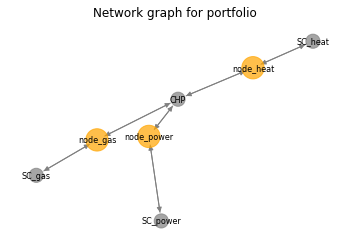

In [2]:
node_power = eao.assets.Node('node_power')
node_heat = eao.assets.Node('node_heat')
node_gas = eao.assets.Node('node_gas')

timegrid = eao.assets.Timegrid(dt.date(2021, 1, 1), dt.date(2021, 1, 2), freq='h', main_time_unit='h')
simple_contract_power = eao.assets.SimpleContract(name='SC_power', price='price_power', nodes=node_power,
                                             min_cap=-30., max_cap=20)
simple_contract_heat = eao.assets.SimpleContract(name='SC_heat', price='price_heat', nodes=node_heat,
                                             min_cap=-30., max_cap=20.)
simple_contract_gas = eao.assets.SimpleContract(name='SC_gas', price='price_gas', nodes=node_gas,
                                             min_cap=-30., max_cap=20.)


chpasset = eao.assets.CHPAsset(name='CHP', 
                               nodes=[node_power, node_heat, node_gas],
                               min_cap=5., 
                               max_cap=30.,
                               extra_costs=0,
                               freq='h',
                               conversion_factor_power_heat=0.5, 
                               max_share_heat=0.5,
                               ramp=20, 
                               start_costs=1., 
                               running_costs=0., 
                               min_runtime=0, 
                               time_already_running=0., 
                               min_downtime=6.,
                               time_already_off=3.,
                               last_dispatch=0., 
                               start_fuel=0)

prices = {'price_power': np.sin(0.5*np.pi * np.arange(timegrid.T)*np.pi/10)+2,
          'price_heat': np.cos(0.5*np.pi * np.arange(timegrid.T)*np.pi/10)+2, 
          'price_gas': np.ones(timegrid.T)*2, 
          }

portfolio = eao.portfolio.Portfolio([chpasset, simple_contract_power, simple_contract_heat, simple_contract_gas])
eao.network_graphs.create_graph(portf = portfolio)

### Performing the Optimization

In [3]:
op = portfolio.setup_optim_problem(prices, timegrid)
res = op.optimize(solver="GLPK_MI")
# res = op.optimize(solver="GLPK", make_soft_problem=True)  # Relax bool variables, i.e. allow "half on"
out = eao.io.extract_output(portfolio, op, res, prices)
out['summary']

...MIP problem configured. Beware of potentially long optimization and other issues inherent to MIP


,Values
Parameter,
status,successful
value,184.951996


### Plotting the Results

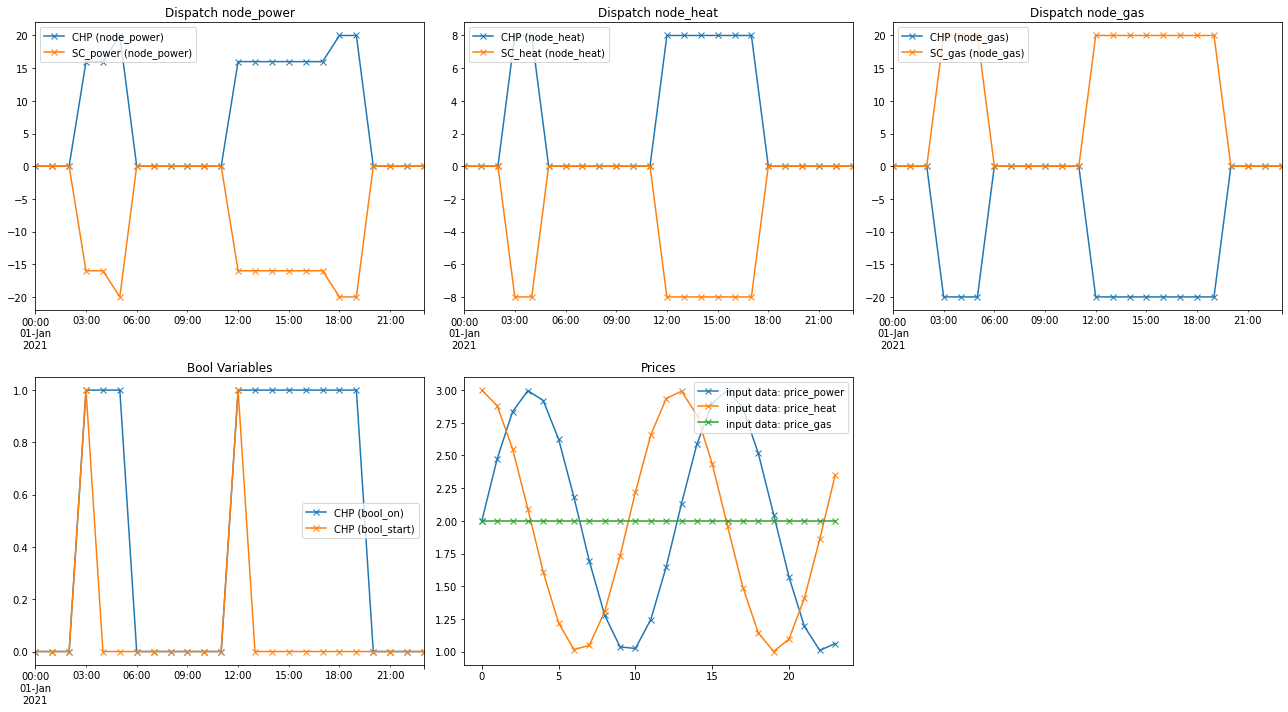

In [4]:
# Define the grid size to display the figures:
num_imgs_per_row = 3
num_nodes = len(portfolio.nodes)
num_img_rows=int(np.ceil((num_nodes+2)/num_imgs_per_row))
fig, ax = plt.subplots(num_img_rows, num_imgs_per_row, tight_layout = True, figsize=(18,5*num_img_rows))
ax = ax.reshape(-1)

# Plot the dispatch for each node:
current_ax=0
dispatch_per_node = {node: [] for node in portfolio.nodes}
for mycol in out['dispatch'].columns.values:
    for node in dispatch_per_node:
        if '(' + node + ')' in mycol:
            dispatch_per_node[node].append(mycol)
for node in dispatch_per_node:
    out['dispatch'][dispatch_per_node[node]].plot(ax=ax[current_ax], style='-x')
    ax[current_ax].set_title("Dispatch " + node)
    current_ax+=1

# Plot internal variables:
for v in out['internal_variables']:
    out['internal_variables'][v].plot(ax=ax[current_ax], style='-x', label=v)
if out['internal_variables'].shape[1] == 0:
    ax[current_ax].text(0.4, 0.5, "No bool variables present")
ax[current_ax].set_title('Bool Variables')
ax[current_ax].legend()
current_ax+=1

# Plot prices
for key in out['prices']:
    out['prices'][key].plot(ax=ax[current_ax], style='-x', label=key)
ax[current_ax].set_title('Prices')
ax[current_ax].legend()

# Remove empty axes:
for i in range(current_ax+1, len(ax)):
    fig.delaxes(ax[i])